# Project AI (AVR)

## Inports

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from IPython import display

## Variables

In [2]:
words = False

if words:
    DATASET_PATH = "../Data/Words"  # Words
    modelSave = "saved-Words"
    HZ = 16000  # Words

else:
    DATASET_PATH = "../Data/DigitNew" # Digits
    modelSave = "saved-Digit-V2"
    HZ = 48000 # Digits

seed = 42
EPOCHS = 40
tf.random.set_seed(seed)
np.random.seed(seed)

## Read dataset and split it in to train/validation dataset
Convert audio to the same lenght

In [3]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=DATASET_PATH,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=HZ,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 30000 files belonging to 10 classes.
Using 24000 files for training.
Using 6000 files for validation.

label names: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


## Plot dataset amount of records

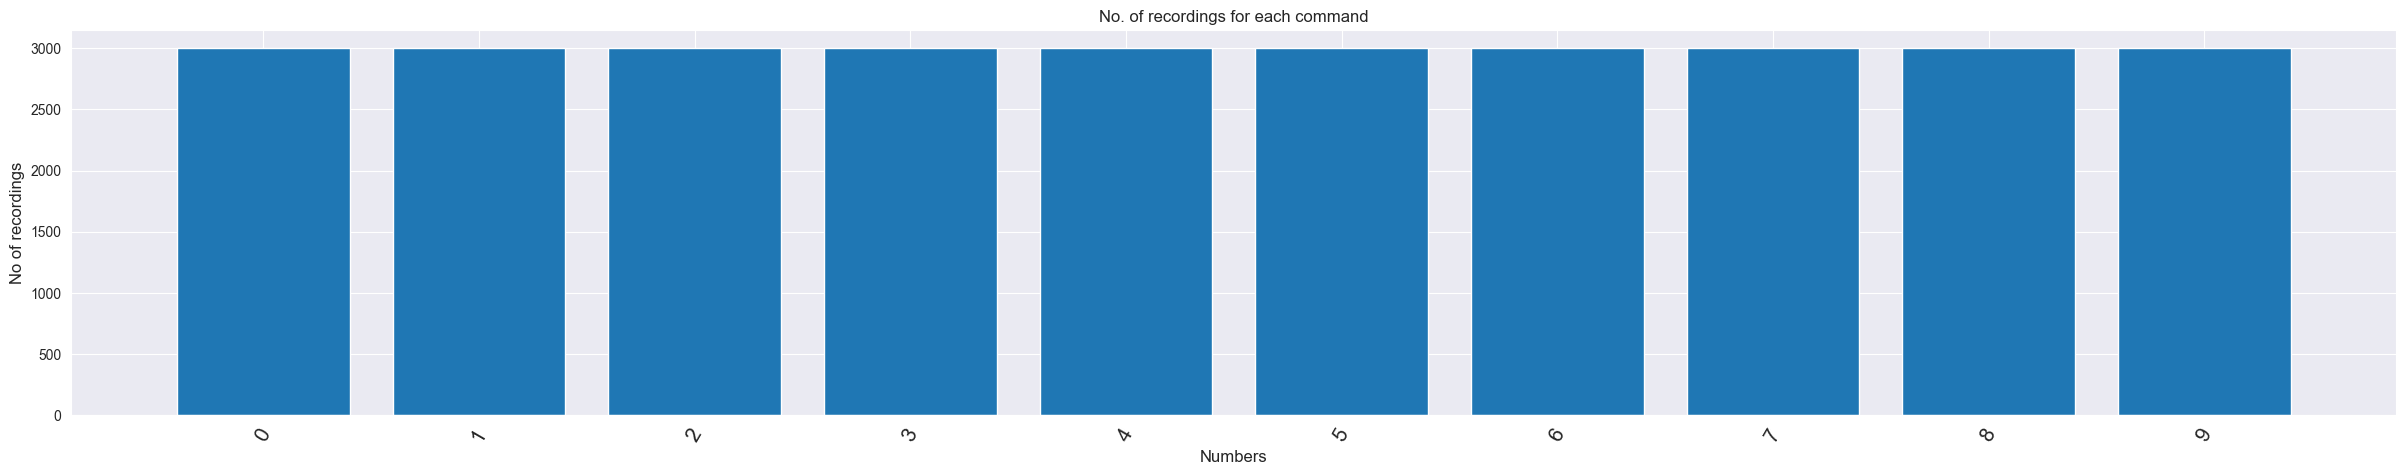

In [4]:
no_of_recordings = []
for label in label_names:
    waves = [f for f in os.listdir(DATASET_PATH + '/' + label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))

#plot
plt.figure(figsize=(30, 5))
index = np.arange(len(label_names))
plt.bar(index, no_of_recordings)
plt.xlabel('Numbers', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, label_names, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [5]:
train_ds.element_spec

(TensorSpec(shape=(None, 48000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

## Stereo to mono

In [6]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels


train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [7]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [8]:
for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_labels.shape)

(64, 48000)
(64,)


In [9]:
label_names[[1, 1, 3, 0]]

array(['1', '1', '3', '0'], dtype='<U1')

## Plot Some data as wavefroms

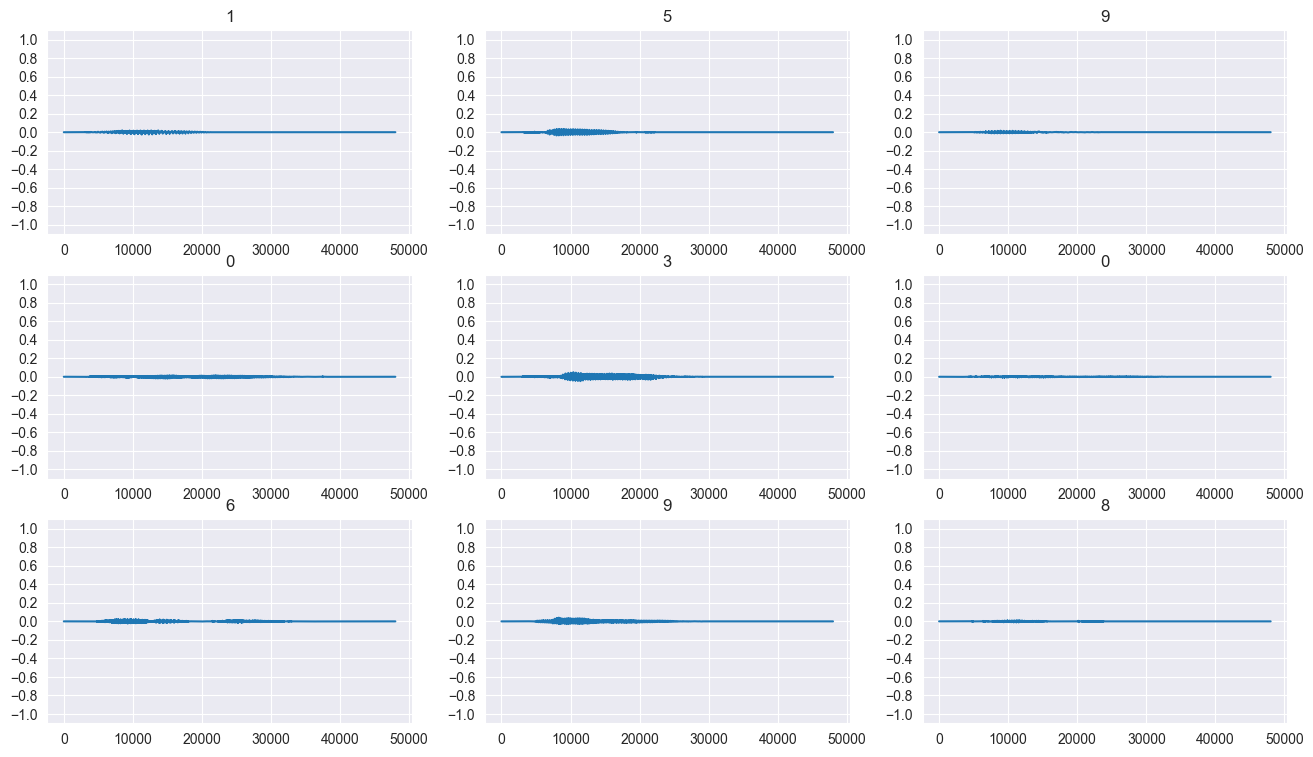

In [10]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    if i >= n:
        break
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(example_audio[i].numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label_names[example_labels[i]]
    ax.set_title(label)
    ax.set_ylim([-1.1, 1.1])

plt.show()

## Waveform to spectogram function
also removes null values

In [11]:
def get_spectrogram(waveform):
    spect = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    spect = tf.abs(spect)
    spect = spect[..., tf.newaxis]
    return spect


## Play some audio data + Wavefrom shape + mel spectrum shape

In [12]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=HZ))

Label: 1
Waveform shape: (48000,)
Spectrogram shape: (374, 129, 1)
Audio playback


Label: 5
Waveform shape: (48000,)
Spectrogram shape: (374, 129, 1)
Audio playback


Label: 9
Waveform shape: (48000,)
Spectrogram shape: (374, 129, 1)
Audio playback


## Plot Spectogram Function

In [13]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

## Plot Waveform and Mel Spectrum

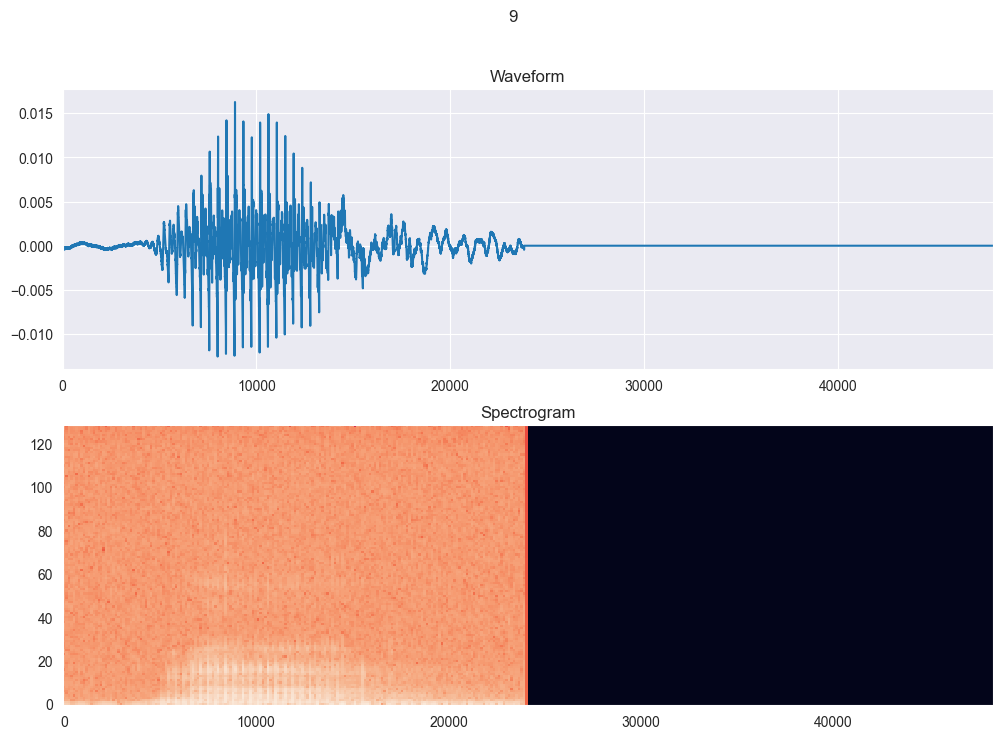

In [14]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, HZ])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

## Map dataset to spectogram dataset

In [15]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)

In [16]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [17]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

## Plot some Mel spectograms

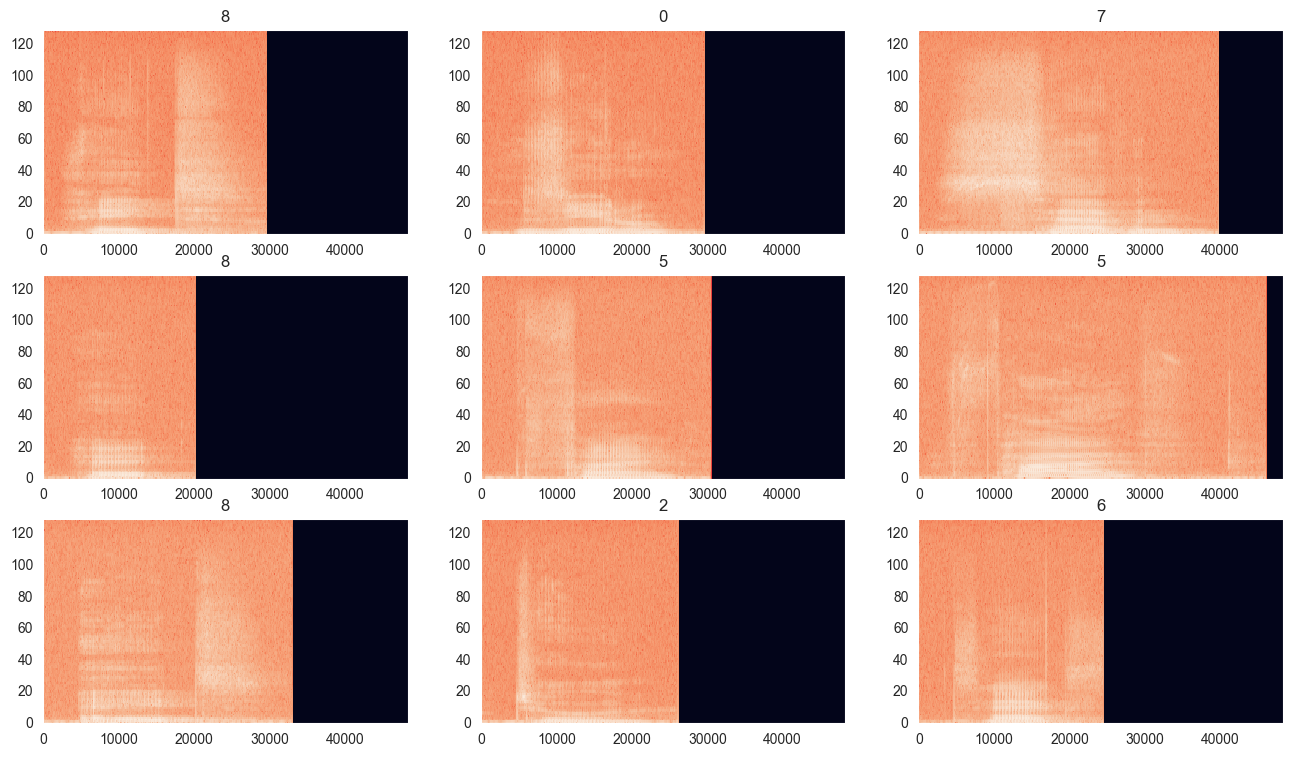

In [18]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [19]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)


## Model

In [20]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = tf.keras.layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    # Downsample the input.
    tf.keras.layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_labels),
])

model.summary()

Input shape: (374, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

## Model settings

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

## Train

In [22]:
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/40
375/375 [==============================] - 23s 60ms/step - loss: 0.6086 - accuracy: 0.8142 - val_loss: 0.1919 - val_accuracy: 0.9462
Epoch 2/40
375/375 [==============================] - 21s 55ms/step - loss: 0.2466 - accuracy: 0.9225 - val_loss: 0.1413 - val_accuracy: 0.9502
Epoch 3/40
375/375 [==============================] - 20s 55ms/step - loss: 0.1680 - accuracy: 0.9494 - val_loss: 0.0806 - val_accuracy: 0.9743
Epoch 4/40
375/375 [==============================] - 21s 55ms/step - loss: 0.1240 - accuracy: 0.9607 - val_loss: 0.0648 - val_accuracy: 0.9779
Epoch 5/40
375/375 [==============================] - 22s 58ms/step - loss: 0.1022 - accuracy: 0.9678 - val_loss: 0.0696 - val_accuracy: 0.9796
Epoch 6/40
375/375 [==============================] - 22s 58ms/step - loss: 0.0941 - accuracy: 0.9699 - val_loss: 0.0471 - val_accuracy: 0.9850
Epoch 7/40
375/375 [==============================] - 21s 57ms/step - loss: 0.0755 - accuracy: 0.9771 - val_loss: 0.0428 - val_accuracy:

## Plot Accurancy and Loss

Text(0, 0.5, 'Accuracy [%]')

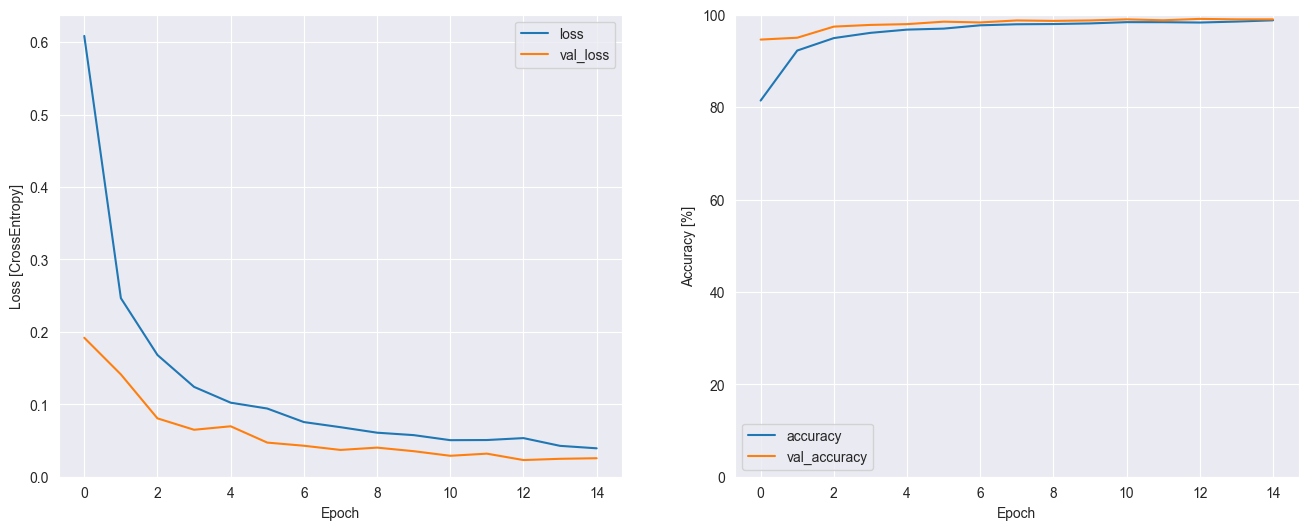

In [23]:
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')


## Evaluate

In [24]:
model.evaluate(test_spectrogram_ds, return_dict=True)

47/47 [==============================] - 3s 56ms/step - loss: 0.3020 - accuracy: 0.9874


{'loss': 0.3020286560058594, 'accuracy': 0.9873670339584351}

## Predict

In [25]:
y_pred = model.predict(test_spectrogram_ds)

47/47 [==============================] - 1s 11ms/step


## PLot heatmap results

In [26]:
y_pred = tf.argmax(y_pred, axis=1)

In [27]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s, lab: lab)), axis=0)

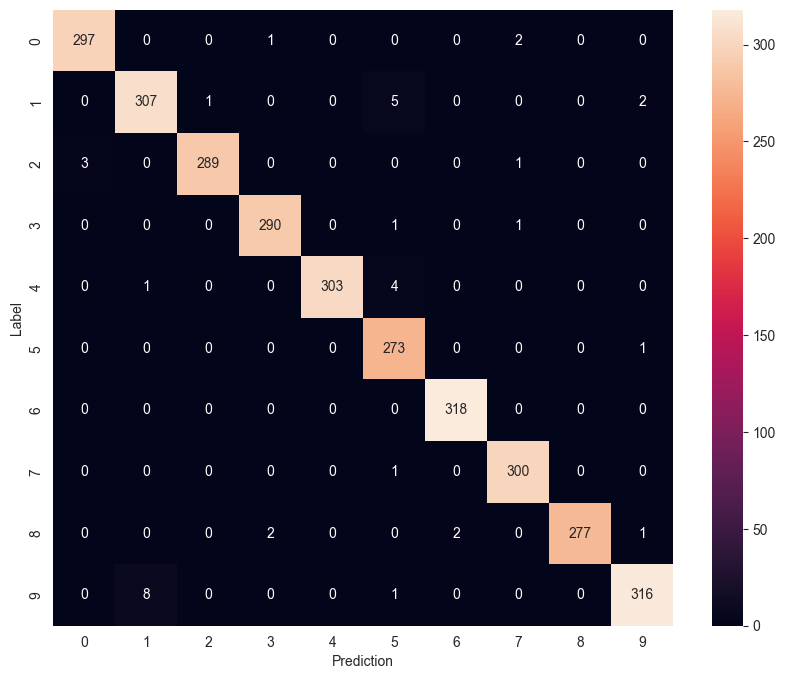

In [28]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Predict new Data + plot results

# Model Export  <https://www.tensorflow.org/tutorials/audio/simple_audio>

In [29]:
class ExportModel(tf.Module):
    def __init__(self, model):
        self.model = model

        self.__call__.get_concrete_function(
            x=tf.TensorSpec(shape=(), dtype=tf.string))
        self.__call__.get_concrete_function(
            x=tf.TensorSpec(shape=[None, HZ], dtype=tf.float32))

    @tf.function
    def __call__(self, x):
        if x.dtype == tf.string:
            x = tf.io.read_file(x)
            x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=HZ, )
            x = tf.squeeze(x, axis=-1)
            x = x[tf.newaxis, :]
            print("url found")

        x = get_spectrogram(x)
        result = self.model(x, training=False)

        class_ids = tf.argmax(result, axis=-1)
        class_names = tf.gather(label_names, class_ids)
        return result
        # return {'predictions':result,
        #         'class_ids': class_ids,
        #         'class_names': class_names}


In [30]:
export = ExportModel(model)
tf.saved_model.save(export, modelSave)

url found
url found


INFO:tensorflow:Assets written to: saved-Digit-V2\assets


INFO:tensorflow:Assets written to: saved-Digit-V2\assets
